In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import quandl as ql
import datetime as dt

In [2]:
# U.S. Total Stock Market
# U.S. Large Cap Stock Market
# U.S. Small Cap Stock Market
# International Total Stock Market
# International Developed Stock Market
# U.S. Total Bond Market
# U.S. Short Term Bond Market
# International Total Bond Market
# U.S. Total Money Market
# U.S. Real Estate Investment Trust

# Data Query and Range Delimiting
ptheoryquery1 = web.DataReader(['AGG', 'BWX', 'CWI', 'IYR', 'SHY', 'SPY', 'VB', 'VEA', 'VTI'], 'yahoo', '2006-04-01',
                                '2016-05-01')
cptheory = ptheoryquery1['Close']
mptheoryall = cptheory.asfreq('M', method='pad')
mptheoryall.columns = ['mbonds', 'mibonds', 'mistocks', 'mreit', 'mshort', 'mlarge', 'msmall', 'mdeveloped', 'mstocks']

ptheoryquery2 = ql.get("USTREASURY/YIELD.1", collapse="monthly")
ptheoryquery2 = ptheoryquery2['2006-04-01':'2016-04-30']
ptheoryquery2 = pd.DataFrame(ptheoryquery2)
ptheoryquery2.columns = ['mcash']
mptheoryall.loc[:, 'mcash'] = ptheoryquery2['mcash']


In [3]:
# Monthly and Annual Returns Calculation
mptheoryall.loc[:, 'mstocksret'] = mptheoryall.loc[:, 'mstocks'] / mptheoryall.loc[:, 'mstocks'].shift(1) - 1
mptheoryall.loc[:, 'astocksret'] = mptheoryall.loc[:, 'mstocks'] / mptheoryall.loc[:, 'mstocks'].shift(12) - 1

mptheoryall.loc[:, 'mlargeret'] = mptheoryall.loc[:, 'mlarge'] / mptheoryall.loc[:, 'mlarge'].shift(1) - 1
mptheoryall.loc[:, 'alargeret'] = mptheoryall.loc[:, 'mlarge'] / mptheoryall.loc[:, 'mlarge'].shift(12) - 1

mptheoryall.loc[:, 'msmallret'] = mptheoryall.loc[:, 'msmall'] / mptheoryall.loc[:, 'msmall'].shift(1) - 1
mptheoryall.loc[:, 'asmallret'] = mptheoryall.loc[:, 'msmall'] / mptheoryall.loc[:, 'msmall'].shift(12) - 1

mptheoryall.loc[:, 'mistocksret'] = mptheoryall.loc[:, 'mistocks'] / mptheoryall.loc[:, 'mistocks'].shift(1) - 1
mptheoryall.loc[:, 'aistocksret'] = mptheoryall.loc[:, 'mistocks'] / mptheoryall.loc[:, 'mistocks'].shift(12) - 1

mptheoryall.loc[:, 'mdevelopedret'] = mptheoryall.loc[:, 'mdeveloped'] / mptheoryall.loc[:, 'mdeveloped'].shift(1) - 1
mptheoryall.loc[:, 'adevelopedret'] = mptheoryall.loc[:, 'mdeveloped'] / mptheoryall.loc[:, 'mdeveloped'].shift(12) - 1

mptheoryall.loc[:, 'mbondsret'] = mptheoryall.loc[:, 'mbonds'] / mptheoryall.loc[:, 'mbonds'].shift(1) - 1
mptheoryall.loc[:, 'abondsret'] = mptheoryall.loc[:, 'mbonds'] / mptheoryall.loc[:, 'mbonds'].shift(12) - 1

mptheoryall.loc[:, 'mshortret'] = mptheoryall.loc[:, 'mshort'] / mptheoryall.loc[:, 'mshort'].shift(1) - 1
mptheoryall.loc[:, 'ashortret'] = mptheoryall.loc[:, 'mshort'] / mptheoryall.loc[:, 'mshort'].shift(12) - 1

mptheoryall.loc[:, 'mibondsret'] = mptheoryall.loc[:, 'mibonds'] / mptheoryall.loc[:, 'mibonds'].shift(1) - 1
mptheoryall.loc[:, 'aibondsret'] = mptheoryall.loc[:, 'mibonds'] / mptheoryall.loc[:, 'mibonds'].shift(12) - 1

mptheoryall.loc[:, 'mcashret'] = (mptheoryall.loc[:, 'mcash'] / 100) / 12
mptheoryall.loc[:, 'acashret'] = mptheoryall.loc[:, 'mcash'] / 100

mptheoryall.loc[:, 'mreitret'] = mptheoryall.loc[:, 'mreit'] / mptheoryall.loc[:, 'mreit'].shift(1) - 1
mptheoryall.loc[:, 'areitsret'] = mptheoryall.loc[:, 'mreit'] / mptheoryall.loc[:, 'mreit'].shift(12) - 1


In [4]:
# 4.1. Portfolio Performance

# 4.1.1. Sharpe Ratio
mlargemean = np.nanmean(mptheoryall.loc[:, 'mlargeret'])
mcashmean = np.nanmean(mptheoryall.loc[:, 'mcashret'])
mlargestdev = np.nanstd(mptheoryall.loc[:, 'mlargeret'])
mlargesharpe = (mlargemean - mcashmean) / mlargestdev


In [5]:
# 4.1.2. Treynor Ratio
# Calculate CAPM Beta Coefficient and convert all NaN value to 0 as cov function doesn't have exception
mptheoryall[np.isnan(mptheoryall)] = 0
mlargecov = np.cov(mptheoryall.loc[:, 'mstocksret'], mptheoryall.loc[:, 'mlargeret'])
mstocksstdev2 = np.nanstd(mptheoryall.loc[:, 'mstocksret']) ** 2
mbetacapm = mlargecov.item(1) / mstocksstdev2
# Calculate Treynor Ratio
mlargetreynor = (mlargemean - mcashmean) / mbetacapm


In [6]:
# 4.1.3. Sortino Ratio
# Calculate Downside Deviation
mlargeddev = 0
for i, r in enumerate(mptheoryall.iterrows()):
    if r[1]['mlargeret'] - mcashmean < 0:
        mlargeddev += ((r[1]['mlargeret'] - mcashmean) ** 2) / len(mptheoryall)
    else:
        mlargeddev += 0
# Calculate Sortino Ratio
mlargesortino = (mlargemean - mcashmean) / np.sqrt(mlargeddev)


In [7]:
# 4.1.4. Kelly Ratio
mlargekelly = ((mlargemean - mcashmean) / (mlargestdev ** 2)) / 2


In [9]:
# 4.2.1. Naive Global Portfolio
mptheoryall.loc[:, 'mnaiveret'] = 0.25 * mptheoryall.loc[:, 'mbondsret'] + 0.25 * mptheoryall.loc[:, 'mstocksret'] \
                                  + 0.25 * mptheoryall.loc[:, 'mibondsret'] + 0.25 * mptheoryall.loc[:, 'mistocksret']


In [10]:
# 4.2.2. Roche Global Portfolio
mptheoryall.loc[:, 'mrocheret'] = 0.24 * mptheoryall.loc[:, 'mbondsret'] + 0.18 * mptheoryall.loc[:, 'mstocksret'] \
                                  + 0.33 * mptheoryall.loc[:, 'mibondsret'] + 0.25 * mptheoryall.loc[:, 'mistocksret']


In [11]:
# 4.2.3. Bogle U.S. 60% Stocks, 40% Bonds Portfolio
mptheoryall.loc[:, 'mbogleret'] = 0.40 * mptheoryall.loc[:, 'mbondsret'] + 0.60 * mptheoryall.loc[:, 'mstocksret']


In [12]:
# 4.2.4. Ferri Core Four Portfolio
mptheoryall.loc[:, 'mferriret'] = 0.20 * mptheoryall.loc[:, 'mbondsret'] + 0.48 * mptheoryall.loc[:, 'mstocksret'] \
                                  + 0.24 * mptheoryall.loc[:, 'mistocksret'] + 0.08 * mptheoryall.loc[:, 'mreitret']


In [13]:
# 4.2.5. Bernestein No-Brainer Portfolio
mptheoryall.loc[:, 'mbernret'] = 0.25 * mptheoryall.loc[:, 'mshortret'] + 0.25 * mptheoryall.loc[:, 'mlargeret'] \
                                  + 0.25 * mptheoryall.loc[:, 'msmallret'] + 0.25 * mptheoryall.loc[:, 'mdevelopedret']


In [14]:
# 4.2.6. Benchmark Portfolios Returns Comparison

# Cumulative Monthly Returns Calculation
mptheoryall.loc[:, 'mnaivecum'] = np.cumprod(mptheoryall.loc[:, 'mnaiveret'] + 1) - 1
mptheoryall.loc[:, 'mrochecum'] = np.cumprod(mptheoryall.loc[:, 'mrocheret'] + 1) - 1
mptheoryall.loc[:, 'mboglecum'] = np.cumprod(mptheoryall.loc[:, 'mbogleret'] + 1) - 1
mptheoryall.loc[:, 'mferricum'] = np.cumprod(mptheoryall.loc[:, 'mferriret'] + 1) - 1
mptheoryall.loc[:, 'mberncum'] = np.cumprod(mptheoryall.loc[:, 'mbernret'] + 1) - 1


In [15]:
# Annualized Monthly Returns Calculation
mptheoryall.loc[:, 'mnaivecuma'] = np.cumprod(mptheoryall.loc[:, 'mnaiveret'] + 1)  ** (12 / len(mptheoryall)) - 1
mptheoryall.loc[:, 'mrochecuma'] = np.cumprod(mptheoryall.loc[:, 'mrocheret'] + 1)  ** (12 / len(mptheoryall)) - 1
mptheoryall.loc[:, 'mboglecuma'] = np.cumprod(mptheoryall.loc[:, 'mbogleret'] + 1)  ** (12 / len(mptheoryall)) - 1
mptheoryall.loc[:, 'mferricuma'] = np.cumprod(mptheoryall.loc[:, 'mferriret'] + 1)  ** (12 / len(mptheoryall)) - 1
mptheoryall.loc[:, 'mberncuma'] = np.cumprod(mptheoryall.loc[:, 'mbernret'] + 1)  ** (12 / len(mptheoryall)) - 1


In [16]:
# Obtain last Annualized Monthly Return
lastdate = dt.datetime(2016, 3, 31)
mnaivereta = mptheoryall.at[lastdate, 'mnaivecuma']
mrochereta = mptheoryall.at[lastdate, 'mrochecuma']
mboglereta = mptheoryall.at[lastdate, 'mboglecuma']
mferrireta = mptheoryall.at[lastdate, 'mferricuma']
mbernreta = mptheoryall.at[lastdate, 'mberncuma']


In [17]:
# Annualized Monthly Standard Deviation Calculation
mnaivestdeva = np.std(mptheoryall.loc[:, 'mnaiveret']) * np.sqrt(12)
mrochestdeva = np.std(mptheoryall.loc[:, 'mrocheret']) * np.sqrt(12)
mboglestdeva = np.std(mptheoryall.loc[:, 'mbogleret']) * np.sqrt(12)
mferristdeva = np.std(mptheoryall.loc[:, 'mferriret']) * np.sqrt(12)
mbernstdeva = np.std(mptheoryall.loc[:, 'mbernret']) * np.sqrt(12)


In [18]:
# 4.2.7 Portfolio Theory Charts and Tables

# U.S. Large Cap Stocks Portfolio Performance Metrics Table
mperfdata = [{'0': '', '1': 'mlargeret'},
        {'0': 'Sharpe Ratio:', '1': mlargesharpe},
        {'0': 'Treynor Ratio:', '1': mlargetreynor},
        {'0': 'Sortino Ratio:', '1': mlargesortino},
        {'0': 'Half Kelly Ratio:', '1': mlargekelly}]
mperftable = pd.DataFrame(mperfdata)
print("")
print(mperftable)
print("")



                   0           1
0                      mlargeret
1      Sharpe Ratio:   0.0895896
2     Treynor Ratio:  0.00405472
3     Sortino Ratio:    0.124954
4  Half Kelly Ratio:     1.01838



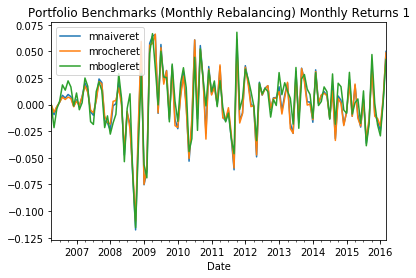

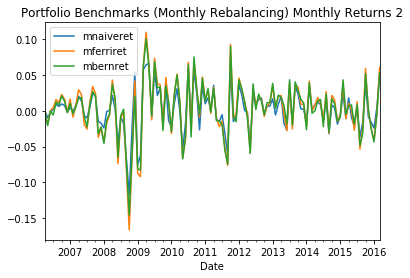

In [20]:
# Benchmark Potfolios Monthly Returns Chart
mptheoryall.plot(y=['mnaiveret', 'mrocheret', 'mbogleret'])
plt.title('Portfolio Benchmarks (Monthly Rebalancing) Monthly Returns 1')
plt.legend(loc='upper left')
plt.show()

mptheoryall.plot(y=['mnaiveret', 'mferriret', 'mbernret'])
plt.title('Portfolio Benchmarks (Monthly Rebalancing) Monthly Returns 2')
plt.legend(loc='upper left')
plt.show()


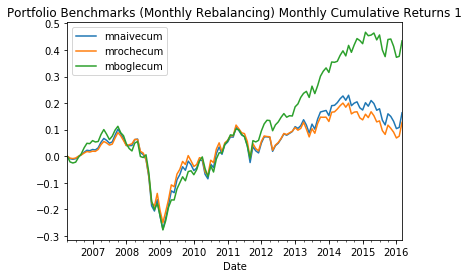

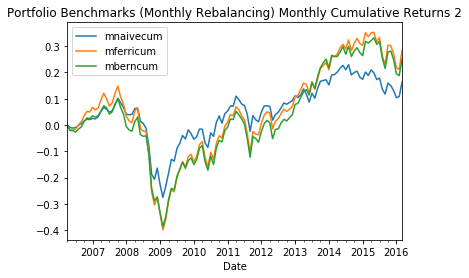

In [21]:
# Benchmark Potfolios Cumulative Monthly Returns Chart
mptheoryall.plot(y=['mnaivecum', 'mrochecum', 'mboglecum'])
plt.title('Portfolio Benchmarks (Monthly Rebalancing) Monthly Cumulative Returns 1')
plt.legend(loc='upper left')
plt.show()

mptheoryall.plot(y=['mnaivecum', 'mferricum', 'mberncum'])
plt.title('Portfolio Benchmarks (Monthly Rebalancing) Monthly Cumulative Returns 2')
plt.legend(loc='upper left')
plt.show()


In [22]:
# Benchmark Potfolios Annualized Monthly Return and Standard Deviation Table
abenchcompdata = [{'0': '', '1': 'mnaiveret', '2': 'mrocheret', '3': 'mbogleret', '4': 'mferriret', '5': 'mbernret'},
        {'0': 'Annualized Return', '1': mnaivereta, '2': mrochereta, '3': mboglereta, '4': mferrireta, '5': mbernreta},
        {'0': 'Annualized Standard Deviation', '1': mnaivestdeva, '2': mrochestdeva, '3': mboglestdeva,
         '4': mferristdeva, '5': mbernstdeva}]
abenchcomptable = pd.DataFrame(abenchcompdata)
print("")
print(abenchcomptable)
print("")


                               0          1          2          3          4  \
0                                 mnaiveret  mrocheret  mbogleret  mferriret   
1              Annualized Return  0.0152659  0.0120934  0.0367312  0.0254015   
2  Annualized Standard Deviation   0.101296   0.096242  0.0962802   0.136379   

           5  
0   mbernret  
1  0.0226291  
2   0.127844  

